# Face Mask Detection With Transfer Learning

## Import Libraries

In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-07-07 01:18:48.658142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751851129.137953      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751851129.252621      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Sample Data Visualization
maskeli ve maskesiz görsellerden birkaçını ve bunların boyutlarını inceleyelim

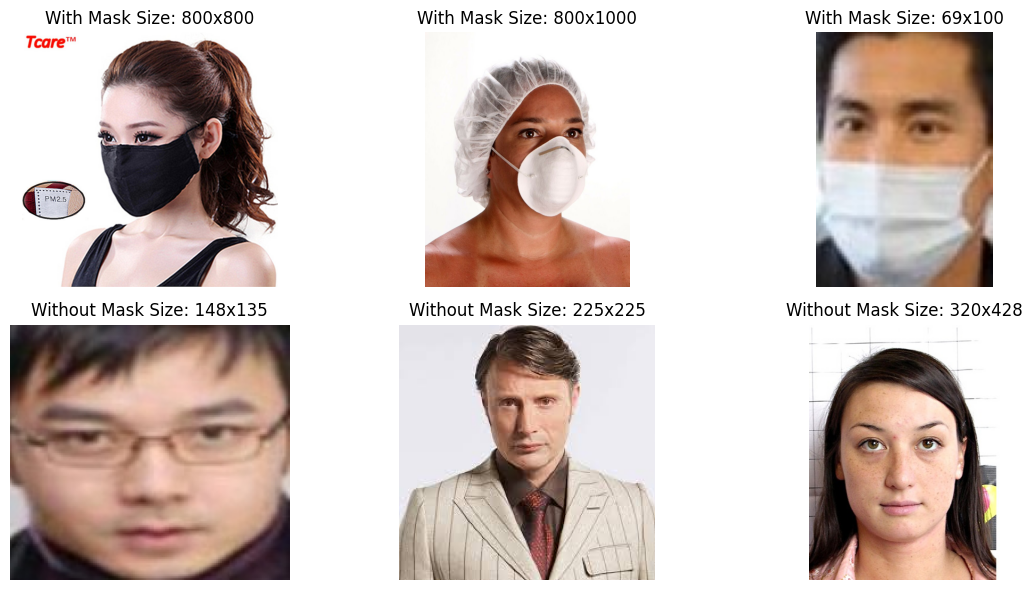

With Mask: 3725 image
Without Mask: 3828 image


In [3]:
# Klasör ve sınıf bilgileri
classes = {
    "With Mask": "/kaggle/input/face-mask-dataset/data/with_mask",
    "Without Mask": "/kaggle/input/face-mask-dataset/data/without_mask"
}

plt.figure(figsize=(12, 6))

index = 1
for label, folder in classes.items():
    img_files = os.listdir(folder)[:3]
    for img_name in img_files:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        height, width, channels = img.shape
     

        plt.subplot(2, 3, index)
        plt.imshow(img)
        plt.title(f"{label} Size: {width}x{height}")
        plt.axis("off")
        index += 1

plt.tight_layout()
plt.show()


for label, folder in classes.items():
    count = len(os.listdir(folder))
    print(f"{label}: {count} image")

maskeli ve maskesiz görsellerin dağılımı arasında büyük bir farklılık olmadığı için herhangi bir işlem yapılmadı

### Data Preparation & CLAHE-based Image Enhancement
Modeli eğitmeden önce, verisetindeki görseller eğitim (%80) ve doğrulama (%20) olarak ayrılmıştır. Daha sonra tüm görsellere Contrast Limited Adaptive Histogram Equalization (CLAHE) uygulanarak kontrast iyileştirmesi yapılmıştır. CLAHE, özellikle düşük kontrastlı görüntülerde detayları daha belirgin hale getirmek için tercih edilmiştir.

İşlem adımları:

1. Görseller önce gri tonlamaya çevrilmiştir.

2. CLAHE uygulanarak kontrast iyileştirilmiştir.

3. Gri görseller tekrar 3 kanallı (RGB) formata dönüştürülerek model girişine uygun hale getirilmiştir.

In [4]:
original_dir = "/kaggle/input/face-mask-dataset/data"
output_dir = "/kaggle/working/data"
categories = ["with_mask", "without_mask"]

for category in categories:
    img_dir = os.path.join(original_dir, category)
    images = os.listdir(img_dir)

    # verisetini %80 train -  %20 validation oranında bölelim
    train_img, val_img = train_test_split(images, test_size=0.2, random_state=42)

    for split, split_img in zip(["train", "val"], [train_img, val_img]):
        split_dir = os.path.join(output_dir, split, category)
        os.makedirs(split_dir, exist_ok=True)

        for img_name in split_img:
            img_path = os.path.join(img_dir, img_name)

            image = cv2.imread(img_path)
            if image is None:
                continue  # görseli oku ve bozuk görseller varsa atla

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # griye çevir

            # CLAHE method
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)
            enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR) # griyi tekrar 3 kanallıya çevirelim (model için gerekli)

            save_path = os.path.join(split_dir, img_name)
            cv2.imwrite(save_path, enhanced_rgb) 

In [5]:
# validation - test klasörlerindeki veri sayısını öğrenelim
split_classes = {
    "Train With Mask": "/kaggle/working/data/train/with_mask",
    "Train Without Mask": "/kaggle/working/data/train/without_mask",
    "Validation With Mask": "/kaggle/working/data/val/with_mask",
    "Validation Without Mask": "/kaggle/working/data/val/without_mask"    
}
for label, folder in split_classes.items():
    count = len(os.listdir(folder))
    print(f"{label}: {count} image")

Train With Mask: 2980 image
Train Without Mask: 3062 image
Validation With Mask: 745 image
Validation Without Mask: 766 image


### Data Loading & Preprocessing
Veri ön işleme adımında, eğitim verisi için ImageDataGenerator ile çeşitli artırma teknikleri uygulanmış; doğrulama verisi yalnızca normalize edilmiştir. Görseller dizin yapısından otomatik olarak etiketlenmiştir

In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    directory="/kaggle/working/data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    directory="/kaggle/working/data/val",  
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

print(f"Tags: {train_data.class_indices}")  

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Tags: {'with_mask': 0, 'without_mask': 1}


### Visual Samples After CLAHE Enhancement
CLAHE uygulamasından sonra verilerimizi ImageDataGenerator ile modele uygun formatta yükledik. Aşağıda, eğitim verisinden rastgele seçilen 6 adet örnek görsel yer almaktadır. Bu görseller, CLAHE sonrası gri seviyede kontrastı artırılmış ve ardından yeniden RGB formatına çevrilmiş haldedir.

Her görselin ait olduğu sınıf etiketi (maske var/yok) başlıkta belirtilmiştir. Bu örnekler sayesinde, uygulanan görsel iyileştirme işleminin sonuçlarını görsel olarak da değerlendirebilme şansı elde ettik.

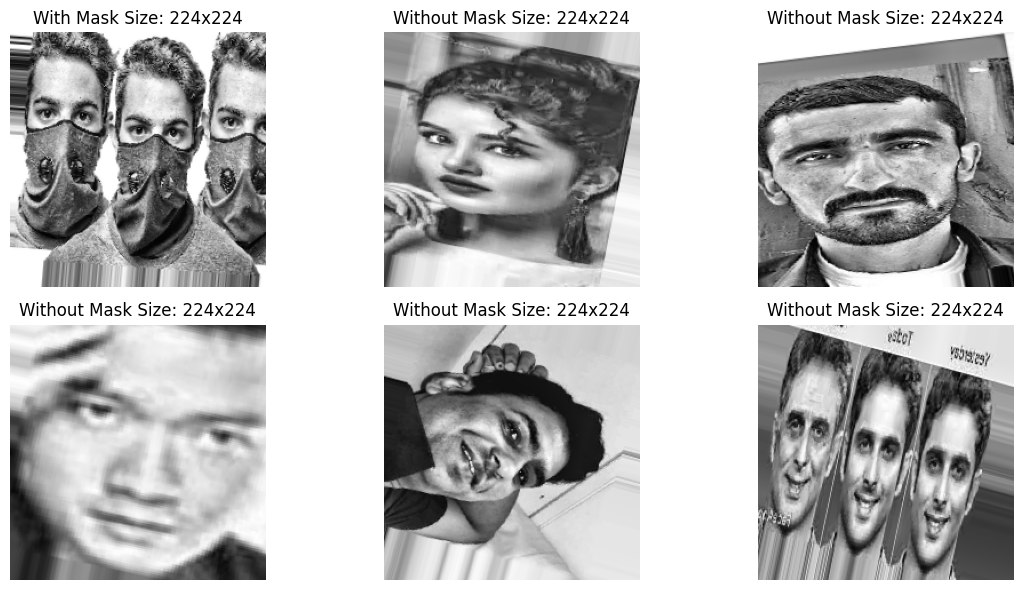

In [7]:
images, labels = next(train_data)

class_names = {0: "With Mask", 1: "Without Mask"}

plt.figure(figsize=(12, 6))

index = 1
for i in range(6):  # İlk 6 görseli göster
    image = images[i]
    label = labels[i]
    height, width, channels = image.shape

    plt.subplot(2, 3, index)
    plt.imshow(image)  
    plt.title(f"{class_names[int(label)]} Size: {width}x{height}")
    plt.axis("off")
    index += 1

plt.tight_layout()
plt.show()

# ResNet 50

### Model Architecture & Compilation
Transfer öğrenme yaklaşımımızda, önceden ImageNet üzerinde eğitilmiş olan ResNet50 modelini taban model (base model) olarak kullandık. Bu modelin ağırlıklarını koruyarak (freeze) yalnızca üst katmanları eğitmeye odaklandık.

Üst katmanlara sırasıyla GlobalAveragePooling, Dense-ReLU katmanları ve Dropout katmanları ekledik. Böylece modelin karmaşık desenleri öğrenme kapasitesi artırılırken aşırı öğrenmenin (overfitting) önüne geçilmesi amaçlandı.

Çıkış katmanı olarak sigmoid aktivasyonlu tek nöron eklendi, çünkü problemimiz iki sınıflı (binary classification) bir problemdir.

Model, Adam optimizer ile binary_crossentropy kaybı üzerinden derlenmiştir. Eğitim sürecinde erken durdurma (EarlyStopping) ve öğrenme oranı azaltma (ReduceLROnPlateau) gibi gelişmiş callback mekanizmaları kullanılarak eğitim sürecinin dinamik kontrolü sağlanmıştır.



In [8]:
# resnet50 modelini yükleyelim, ilk katmanlar haricinde
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# resnet50 freeze işlemi
for layer in base_model.layers:
    layer.trainable = False

# gerekli üst katmanları ekleyelim
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model 
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    callbacks=callbacks,
    epochs=20,
    verbose=1   
)

I0000 00:00:1751851231.581720      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751851231.582440      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751851249.029496     135 service.cc:148] XLA service 0x7c2874003bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751851249.031034     135 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751851249.031060     135 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751851250.960998     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:08:41 22s/step - accuracy: 0.5312 - loss: 0.8061

I0000 00:00:1751851258.076816     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 112s 481ms/step - accuracy: 0.5115 - loss: 0.7656 - val_accuracy: 0.5989 - val_loss: 0.6881 - learning_rate: 1.0000e-04
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 73s 385ms/step - accuracy: 0.5040 - loss: 0.7080 - val_accuracy: 0.4931 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 74s 390ms/step - accuracy: 0.5247 - loss: 0.6932 - val_accuracy: 0.5751 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 74s 394ms/step - accuracy: 0.5450 - loss: 0.6867 - val_accuracy: 0.5970 - val_loss: 0.6680 - learning_rate: 1.0000e-04
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 74s 390ms/step - accuracy: 0.5502 - loss: 0.6847 - val_accuracy: 0.7028 - val_loss: 0.6442 - learning_rate: 1.0000e-04
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 78s 414ms/step - accuracy: 0.5848 - loss: 0.6681 - val_accuracy: 0.7253 - val_loss: 0.6232 - learning_rate: 1.0000e-04
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 77s 408ms/step -

### Training and Validation Performance

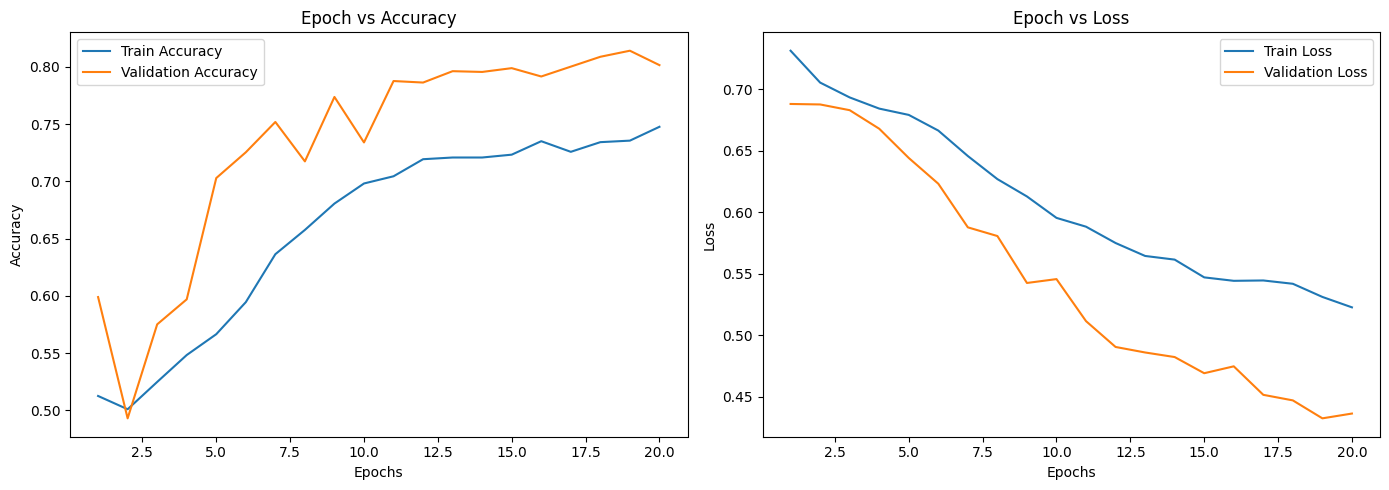

In [9]:
# Eğitim süreci geçmişi
history_dict = model.history.history

# Accuracy ve Loss değerleri
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Classification Report - Confusion Matrix

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step
Classification Report:
              precision    recall  f1-score   support

   with_mask       0.79      0.85      0.82       745
without_mask       0.84      0.78      0.81       766

    accuracy                           0.81      1511
   macro avg       0.82      0.81      0.81      1511
weighted avg       0.82      0.81      0.81      1511

Confusion Matrix:


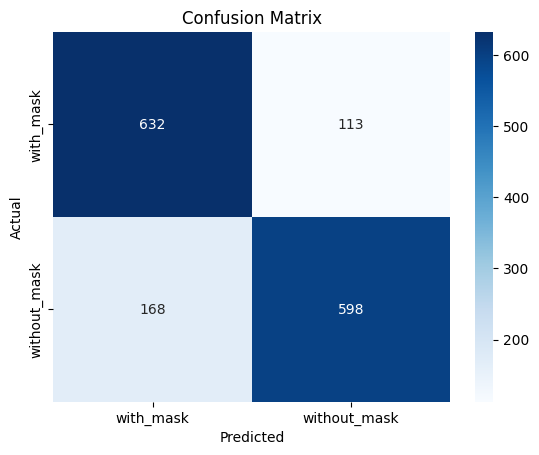

In [10]:
val_data.reset() # Doğrulama verisini baştan sırala -> sıralar predict ile uyuşması için

y_pred_probs = model.predict(val_data) # modelin tahmin ettiği olasılıklar

y_pred = (y_pred_probs > 0.5).astype("int32").flatten() # olasılıkları 0.5'e göre 0 ya da 1 olarak etiketle

y_true = val_data.classes # gerçek etiketleri al

# classification report - confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["with_mask", "without_mask"]))
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["with_mask", "without_mask"], yticklabels=["with_mask", "without_mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Random Image Classification Results

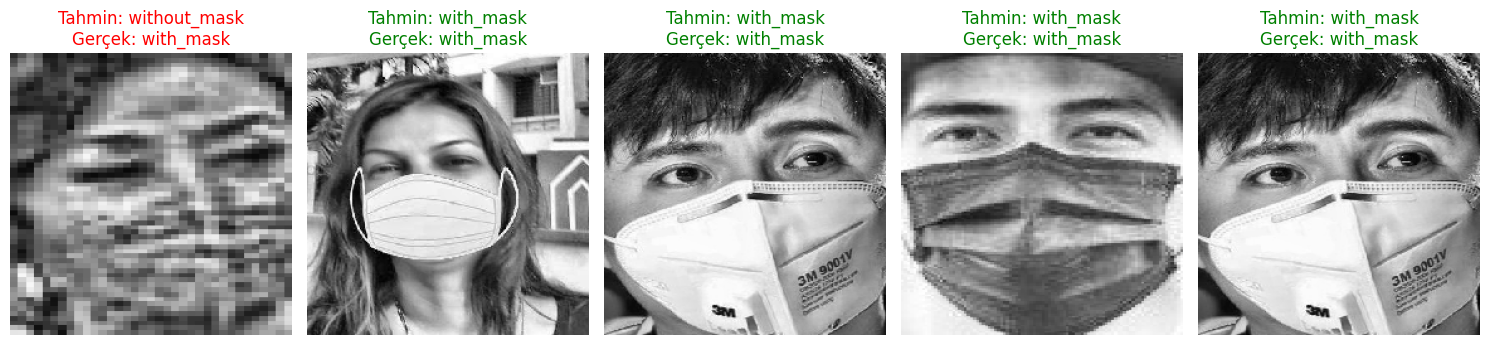

In [13]:
# Rastgele örnek görsel seç ve tahmin et
class_labels = list(val_data.class_indices.keys())
val_data.reset()

x_batch, y_batch = next(val_data)  # batch x = (görüntü), y = (etiket)

plt.figure(figsize=(15, 6))

for i in range(5):
    idx = random.randint(0, len(x_batch) - 1)
    img = x_batch[idx]
    true_label = int(y_batch[idx])

    # Model tahmini (çıktı 0.5'ten büyükse 1, değilse 0 olarak alıyoruz çünkü sigmoid kullanıldı)
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = int(pred[0][0] > 0.5)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title_color = "green" if pred_label == true_label else "red"
    plt.title(
        f"Tahmin: {class_labels[pred_label]}\nGerçek: {class_labels[true_label]}",
        color=title_color
    )

plt.tight_layout()
plt.show()
